In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import pickle
from tqdm.notebook import tqdm
from collections import defaultdict
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.profiler import profile, ProfilerActivity

from sklearn.model_selection import train_test_split

sns.set(font_scale=1.3)
device = 'cuda'

### Data

In [2]:
DATA_PATH = './data'

genders = np.load(f'{DATA_PATH}/genders.npy')
mcc_codes = np.load(f'{DATA_PATH}/mcc_codes.npy')
tr_types = np.load(f'{DATA_PATH}/tr_types.npy')
amounts = np.load(f'{DATA_PATH}/amounts.npy')

In [3]:
train_idx, test_idx = train_test_split(range(len(genders)), shuffle=True, stratify=genders, random_state=42, test_size=0.2)

In [4]:
class BaseDataset(Dataset):
    def __init__(self, mcc_codes, tr_types, amounts, genders, idx):
        self.mcc_codes = mcc_codes[idx]
        self.tr_types = tr_types[idx]
        self.amounts = amounts[idx]
        self.genders = genders[idx]
        self.position = torch.arange(len(mcc_codes[0]))
        
    def __len__(self):
        return len(self.mcc_codes)
    
    def __getitem__(self, idx):
        mcc_code = torch.tensor(self.mcc_codes[idx])
        tr_type = torch.tensor(self.tr_types[idx])
        amount = torch.tensor(self.amounts[idx]).float()
        gender = torch.tensor(self.genders[idx]).float()
        
        inputs = {'mcc_code': mcc_code, 'transaction_type': tr_type, 'amount': amount, 'positions': self.position}
        return inputs, gender

In [5]:
batch_size = 210

train_dataset = BaseDataset(mcc_codes, tr_types, amounts, genders, train_idx)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BaseDataset(mcc_codes, tr_types, amounts, genders, test_idx)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Support utils

In [6]:
def count_parameters(model):
    return sum([np.prod(parameter.shape) for parameter in model.parameters()])


def benchmark(model, input_shape, nwarmup=10, nruns=100):
    model.eval()
    input_data = torch.randn(input_shape)
    input_data = input_data.to(device)

    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
            
    torch.cuda.synchronize()
    timings = []
    with torch.no_grad():
        for i in range(1, nruns + 1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)

    #print('Average batch time: %.2f ms'%(np.mean(timings) * 1000))
    
    return np.mean(timings)


def memory_usage(model, input_shape):
    model.eval()
    inputs = torch.randn(input_shape, device=device)
    with torch.no_grad():
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
            model(inputs)
        
    return sum([key.cuda_memory_usage / (1024 * 1024) for key in prof.key_averages()])

### Models

In [7]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, attention, d_model, dim_feedforward = 2048, dropout = 0.1, activation = nn.ReLU(),
                 layer_norm_eps = 1e-5, norm_first = False, device=None, dtype=None):
        super().__init__()

        factory_kwargs = {'device': device, 'dtype': dtype}
        self.self_attn = attention

        self.linear1 = nn.Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = nn. Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = activation

    def forward(self, src, src_mask = None, src_key_padding_mask = None):
        x = src
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), src_mask, src_key_padding_mask)
            x = x + self._ff_block(self.norm2(x))
        else:
            x = self.norm1(x + self._sa_block(x, src_mask, src_key_padding_mask))
            x = self.norm2(x + self._ff_block(x))
        return x

    def _sa_block(self, x, attn_mask, key_padding_mask):
        x = self.self_attn(x, x, x, attn_mask=attn_mask, key_padding_mask=key_padding_mask, need_weights=False)[0]
        return self.dropout1(x)

    def _ff_block(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)


class BaselineProjector(nn.Module):

    def __init__(
            self,
            embedding_dim,
            num_types,
            num_codes,
            max_sequence_len,
            use_positions=True,
            use_log_amount=True,
            use_layernorm=True,
            eps=1e-5,
            dropout=0.0,
            aggregation_type='sum',
            initializer_range=0.02
    ):
        super().__init__()

        self._embedding_dim = embedding_dim

        self._num_types = num_types
        self._num_codes = num_codes
        self._max_sequence_len = max_sequence_len

        self._use_positions = use_positions
        self._use_log_amount = use_log_amount
        self._use_layernorm = use_layernorm
        self._eps = eps
        self._dropout = dropout
        self._aggregation_type = aggregation_type

        self._types_embedding = nn.Embedding(
            num_embeddings=self._num_types,
            embedding_dim=self._embedding_dim
        )

        self._codes_embedding = nn.Embedding(
            num_embeddings=self._num_codes,
            embedding_dim=self._embedding_dim
        )

        self._amount_layer = nn.Linear(
            in_features=8, out_features=self._embedding_dim
        )

        self._position_embedding = nn.Identity()
        if self._use_positions:
            self._position_embedding = nn.Embedding(
                num_embeddings=self._max_sequence_len,
                embedding_dim=self._embedding_dim
            )

        self._dropout = nn.Dropout(p=self._dropout)
        self._layernorm = nn.LayerNorm(self._embedding_dim, eps=self._eps)

        self._init_weights(initializer_range)

        self._output_dim = self._embedding_dim if self._aggregation_type == 'sum' \
            else (3 + self._use_positions) * self._embedding_dim

    @classmethod
    def create_from_config(cls, config, **kwargs):
        return cls(
            embedding_dim=config['embedding_dim'],
            num_types=kwargs['num_types'],
            num_codes=kwargs['num_codes'],
            max_sequence_len=kwargs['max_sequence_len'],
            use_positions=config.get('use_positions', True),
            use_log_amount=config.get('use_log_amount', True),
            use_layernorm=config.get('use_layernorm', True),
            eps=config.get('eps', 1e-5),
            dropout=config.get('dropout', 0.0),
            aggregation_type=config.get('aggregation_type', 'sum'),
            initializer_range=config.get('initializer_range', 0.02)
        )

    @torch.no_grad()
    def _init_weights(self, initializer_range):
        nn.init.trunc_normal_(
            self._types_embedding.weight.data,
            std=initializer_range,
            a=-2 * initializer_range,
            b=2 * initializer_range
        )

        nn.init.uniform_(self._amount_layer.weight.data, a=initializer_range, b=initializer_range)
        nn.init.uniform_(self._amount_layer.bias.data, a=initializer_range, b=initializer_range)

        nn.init.trunc_normal_(
            self._codes_embedding.weight.data,
            std=initializer_range,
            a=-2 * initializer_range,
            b=2 * initializer_range
        )

        if self._use_positions:
            nn.init.trunc_normal_(
                self._position_embedding.weight.data,
                std=initializer_range,
                a=-2 * initializer_range,
                b=2 * initializer_range
            )

        nn.init.ones_(self._layernorm.weight.data)
        nn.init.zeros_(self._layernorm.bias.data)

    @property
    def output_dim(self):
        return self._output_dim

    def forward(self, inputs):
        mcc_code = inputs['mcc_code']  # (all_batch_events)
        transaction_type = inputs['transaction_type']  # (all_batch_events)
        amount = inputs['amount']  # (all_batch_events)

        mcc_code_embeddings = self._dropout(self._codes_embedding(mcc_code))  # (all_batch_events, embedding_dim)
        transaction_type_embeddings = self._dropout(self._types_embedding(transaction_type))  # (all_batch_events, embedding_dim)

        if self._use_log_amount:
            amount = torch.sign(amount) * torch.log(1. + torch.abs(amount))
        amount_embeddings = self._dropout(self._amount_layer(amount)).unsqueeze(1)

        embeddings = [mcc_code_embeddings, transaction_type_embeddings, amount_embeddings]  # (3, all_batch_events, embedding_dim)

        if self._use_positions:
            position = inputs['positions']  # (all_batch_events)
            position_embeddings = self._position_embedding(position)  # (all_batch_events, embedding_dim)
            embeddings.append(position_embeddings)

        if self._aggregation_type == 'sum':
            embedding = None
            for e in embeddings:
                if embedding is None:
                    embedding = e
                else:
                    embedding += e
        else:
            assert self._aggregation_type == 'concat'
            embedding = torch.cat(embeddings, dim=0)

        return embedding


class BaselineEncoder(nn.Module):

    def __init__(
            self,
            attention,
            hidden_size,
            num_layers,
            dim_feedforward,
            dropout=0.0,
            activation=nn.ReLU(),
            layer_norm_eps=1e-5,
            input_dim=None,
            output_dim=None,
            user_cls_only=False,
            initializer_range=0.02
    ):
        super().__init__()

        self._input_projection = nn.Identity()
        if input_dim is not None:
            self._input_projection = nn.Linear(input_dim, hidden_size)

        encoder_layer = TransformerEncoderLayer(
            attention, 
            d_model=hidden_size, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            activation=activation,
            layer_norm_eps=layer_norm_eps
        )
        self._encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self._output_projection = nn.Identity()
        if output_dim is not None:
            self._output_projection = nn.Linear(hidden_size, output_dim)

        self._user_cls_only = user_cls_only

        self._init_weights(initializer_range)

    @torch.no_grad()
    def _init_weights(self, initializer_range):
        for key, value in self.named_parameters():
            if 'weight' in key:
                if 'norm' in key:
                    nn.init.ones_(value.data)
                else:
                    nn.init.trunc_normal_(
                        value.data,
                        std=initializer_range,
                        a=-2 * initializer_range,
                        b=2 * initializer_range
                    )
            elif 'bias' in key:
                nn.init.zeros_(value.data)
            else:
                raise ValueError(f'Unknown transformer weight: {key}')

    def forward(self, embeddings):
        embeddings = self._input_projection(embeddings)  # (batch_size, seq_len, emb_dim)
        embeddings = self._encoder(
            src=embeddings
        )  # (batch_size, seq_len, emb_dim)
        embeddings = self._output_projection(embeddings)  # (batch_size, seq_len, output_emb_dim)
        if self._user_cls_only:
            embeddings = embeddings[:, 0, :]  # (batch_size, output_emb_dim)

        return embeddings

In [8]:
import math

import torch
import torch.nn as nn


class GaussianBasisFunctions(object):
    """Function phi(t) = Gaussian(t; mu, sigma_sq)."""
    def __init__(self, mu, sigma):
        self.mu = mu.unsqueeze(0)
        self.sigma = sigma.unsqueeze(0)

    def __repr__(self):
        return f"GaussianBasisFunction(mu={self.mu}, sigma={self.sigma})"

    def __len__(self):
        """Number of basis functions."""
        return self.mu.size(1)

    def _phi(self, t):
        # N(t|0,1)
        return 1. / math.sqrt(2 * math.pi) * torch.exp(-.5 * t**2)

    def _Phi(self, t):
        return .5 * (1 + torch.erf(t / math.sqrt(2)))

    def _integrate_product_of_gaussians(self, mu, sigma_sq):
        sigma = torch.sqrt(self.sigma ** 2 + sigma_sq)
        return self._phi((mu - self.mu) / sigma) / sigma

    def evaluate(self, t):
        # N(t|mu, sigma)
        return self._phi((t - self.mu) / self.sigma) / self.sigma

    def batch_evaluate(self, t):
        t = t.repeat(self.mu.size(0),1) - self.mu.repeat(t.size(0),1).transpose(1,0)
        return self._phi(t / self.sigma) / self.sigma

    def integrate_t2_times_psi(self, a, b):
        """Compute integral int_a^b (t**2) * psi(t)."""
        return (self.mu**2 + self.sigma**2) * (
            self._Phi((b - self.mu) / self.sigma) - self._Phi((a - self.mu) / self.sigma)
        ) - (
            self.sigma * (b + self.mu) * self._phi((b - self.mu) / self.sigma)
        ) + (
            self.sigma * (a + self.mu) * self._phi((a - self.mu) / self.sigma)
        )

    def integrate_t_times_psi(self, a, b):
        """Compute integral int_a^b t * psi(t)."""
        return self.mu * (
            self._Phi((b - self.mu) / self.sigma) - self._Phi((a - self.mu) / self.sigma)
        ) - self.sigma * (
            self._phi((b - self.mu) / self.sigma) - self._phi((a - self.mu) / self.sigma)
        )

    def integrate_psi(self, a, b):
        """Compute integral int_a^b psi(t)."""
        return self._Phi((b - self.mu) / self.sigma) - self._Phi((a - self.mu) / self.sigma)

    def integrate_t2_times_psi_gaussian(self, mu, sigma_sq):
        """Compute integral int N(t; mu, sigma_sq) * t**2 * psi(t)."""
        S_tilde = self._integrate_product_of_gaussians(mu, sigma_sq)
        mu_tilde = (
            self.mu * sigma_sq + mu * self.sigma ** 2
        ) / (
            self.sigma ** 2 + sigma_sq
        )
        sigma_sq_tilde = ((self.sigma ** 2) * sigma_sq) / (self.sigma ** 2 + sigma_sq)
        return S_tilde * (mu_tilde ** 2 + sigma_sq_tilde)

    def integrate_t_times_psi_gaussian(self, mu, sigma_sq):
        """Compute integral int N(t; mu, sigma_sq) * t * psi(t)."""
        S_tilde = self._integrate_product_of_gaussians(mu, sigma_sq)
        mu_tilde = (
            self.mu * sigma_sq + mu * self.sigma ** 2
        ) / (
            self.sigma ** 2 + sigma_sq
        )
        return S_tilde * mu_tilde

    def integrate_psi_gaussian(self, mu, sigma_sq):
        """Compute integral int N(t; mu, sigma_sq) * psi(t)."""
        return self._integrate_product_of_gaussians(mu, sigma_sq)

class ContinuousSoftmaxFunction(torch.autograd.Function):

    @classmethod
    def _expectation_phi_psi(cls, ctx, mu, sigma_sq):
        """Compute expectation of phi(t) * psi(t).T under N(mu, sigma_sq)."""
        num_basis = [len(basis_functions) for basis_functions in ctx.psi]
        total_basis = sum(num_basis)
        V = torch.zeros((mu.shape[0], 2, total_basis), dtype=ctx.dtype,device=ctx.device)
        offsets = torch.cumsum(torch.IntTensor(num_basis).to(ctx.device), dim=0)
        start = 0
        for j, basis_functions in enumerate(ctx.psi):
            V[:, 0, start:offsets[j]] = basis_functions.integrate_t_times_psi_gaussian(mu, sigma_sq)
            V[:, 1, start:offsets[j]] = basis_functions.integrate_t2_times_psi_gaussian(mu, sigma_sq)
            start = offsets[j]
        return V

    @classmethod
    def _expectation_psi(cls, ctx, mu, sigma_sq):
        """Compute expectation of psi under N(mu, sigma_sq)."""
        num_basis = [len(basis_functions) for basis_functions in ctx.psi]
        total_basis = sum(num_basis)
        r = torch.zeros(mu.shape[0], total_basis, dtype=ctx.dtype, device=ctx.device)
        offsets = torch.cumsum(torch.IntTensor(num_basis).to(ctx.device), dim=0)
        start = 0
        for j, basis_functions in enumerate(ctx.psi):
            r[:, start:offsets[j]] = basis_functions.integrate_psi_gaussian(mu, sigma_sq)
            start = offsets[j]
        return r

    @classmethod
    def _expectation_phi(cls, ctx, mu, sigma_sq):
        """Compute expectation of phi under N(mu, sigma_sq)."""
        v = torch.zeros(mu.shape[0], 2, dtype=ctx.dtype, device=ctx.device)
        v[:, 0] = mu.squeeze(1)
        v[:, 1] = (mu**2 + sigma_sq).squeeze(1)
        return v

    @classmethod
    def forward(cls, ctx, theta, psi):
        # We assume a Gaussian.
        # We have:
        # theta = [mu/sigma**2, -1/(2*sigma**2)],
        # phi(t) = [t, t**2],
        # p(t) = Gaussian(t; mu, sigma**2).
        ctx.dtype = theta.dtype
        ctx.device = theta.device
        ctx.psi = psi
        sigma_sq = (-.5 / theta[:, 1]).unsqueeze(1)
        mu = theta[:, 0].unsqueeze(1) * sigma_sq
        r = cls._expectation_psi(ctx, mu, sigma_sq)
        ctx.save_for_backward(mu, sigma_sq, r)
        return r

    @classmethod
    def backward(cls, ctx, grad_output):
        mu, sigma_sq, r = ctx.saved_tensors
        J = cls._expectation_phi_psi(ctx, mu, sigma_sq)
        e_phi = cls._expectation_phi(ctx, mu, sigma_sq)
        e_psi = cls._expectation_psi(ctx, mu, sigma_sq)
        J -= torch.bmm(e_phi.unsqueeze(2), e_psi.unsqueeze(1))
        grad_input = torch.matmul(J, grad_output.unsqueeze(2)).squeeze(2)
        return grad_input, None


class ContinuousSoftmax(nn.Module):
    def __init__(self, psi=None):
        super(ContinuousSoftmax, self).__init__()
        self.psi = psi

    def forward(self, theta):
        return ContinuousSoftmaxFunction.apply(theta, self.psi)


class LongTermAttention(nn.Module):
    # main class to compute continuous attention, with unbounded memory and sticky memories
    # like all 3rd part of article is in this class
    def __init__(self, 
                 head_size: int, 
                 length: int, 
                 target_len: int,  
                 attn_func: str,  # only "softmax"
                 attn_num_basis: int, # number of basis functions
                 attn_drop: float, 
                 infinite_memory: bool, # True
                 n_heads: int, 
                 d_model: int, # embeding size
                 mask: bool, 
                 mask_type: str, # "cnn"
                 kl_regularizer, 
                 sigma_0, 
                 mu_0, 
                 **kwargs):

        super(LongTermAttention, self).__init__()

        #==============INITIALIZING===================

        self.device = 'cuda'

        self.infinite_memory = infinite_memory # whether the memory is infinite
        self.length = length                   # memory length
        self.target_len = target_len           # target length / transformer length
        self.head_size = head_size
        self.attn_num_basis = attn_num_basis   # N - num of basis functions
        self.attn_func = attn_func             # normalizing function
        self.n_head = n_heads                  # number of heads

        self.nb_samples = 512                  # number of samples used for update # TODO: why?
        self.tau = 0.75                        # compressing factor # TODO: why?
        self.ridge_penalty = 1                 # ridge penalty
        self.spacing = 'linear'                # how to get t from [0,1]

        self.mask = mask
        self.mask_type = mask_type
        self.kl_regularizer = kl_regularizer
        self.sigma_0 = sigma_0
        self.mu_0 = mu_0
        
        self.proj_query = nn.Linear(n_heads * head_size, n_heads * head_size, bias=False)
        self.proj_key   = nn.Linear(n_heads * head_size, n_heads * head_size, bias=False)
        self.proj_value = nn.Linear(n_heads * head_size, n_heads * head_size, bias=False)

        self.x_past = None # previous memory vectors
        self.B_past = None # previous coefficient matrix

        padding = True 

        self.attn_dropout = nn.Dropout(attn_drop)
        self.attn_out = nn.Linear(n_heads * head_size, d_model, bias=False)
        self.mu = nn.Linear(attn_num_basis, 1, bias=False)
        self.sigma = nn.Linear(attn_num_basis, 1, bias=False)
        self.softplus = torch.nn.Softplus()

        if self.mask_type == 'cnn':
            # see cnn smoothing (see 3.4)
            self.mask_net = torch.nn.Conv1d(n_heads * head_size, n_heads * head_size, 3, padding=1)

        # normalizing function
        if attn_func == 'softmax':
            self.transform = ContinuousSoftmax(psi=None)
        else:
            assert False

        #================== G matrix computation ======================

        def compute_G(l, psi, positions, padding=True):
            # G = X.T @ F.T @ (F @ F.T + ridge_penalty * I)^(-1)
            # where F = [psi(t_1), ..., psi(t_L)], psi - vector of N RBFs
            # l - length of sequence
            # positions - t

            F = torch.zeros(self.attn_num_basis, positions.size(0))

            basis_functions = psi
            F[:, :] = basis_functions.evaluate(positions.unsqueeze(1)).t()

            I = torch.eye(self.attn_num_basis)
            G = F.t().matmul((F.matmul(F.t()) + self.ridge_penalty * I).inverse()) # actual formula

            if padding: # TODO for what?
                if l % 2:
                    G = G[((l-1)//2):(-(l-1)//2), :]
                else:
                    G = G[(l//2):-(l//2), :]

            return G.to(self.device)

        # ================ POSITIONS, PSIs and Gs ====================
        # get basis functions psi
        sigmas = [.01,.05] # basis function sigmas # TODO why?? heuristic??
        if attn_num_basis % len(sigmas): # TODO why??
            attn_num_basis += (len(sigmas) - attn_num_basis % len(sigmas)) # TODO why??

        self.psi = [None]
        self.Gs  = [None for _ in range(length+1)]
        self.psi = [None]
        lengths  = []

        for i in range(length): # length - memory length 
            self.psi.append([])
            if (i+1) % target_len == 0:
                lengths.append(i+1)
        if length not in lengths:
            lengths.append(length)
            
        for l in lengths:
            # get positions for memory vectors
            self.add_gaussian_basis_functions(self.psi[l], attn_num_basis, sigmas, device=self.device)

            if self.spacing == 'linear': # there was also for "log" but I don't think that we need it
                if padding:
                    if l % 2:
                        shift = 1 / float(l)
                        positions = torch.linspace(-0.5 + shift, 1.5 -shift, 2 * l - 1).to(self.device)
                    else:
                        shift = 1 / float(2*l)
                        positions = torch.linspace(-0.5 + shift, 1.5 - shift, 2 * l).to(self.device)
                else:
                    shift = 1 / float(2*l)
                    positions = torch.linspace(shift, 1-shift, l).to(self.device)
        
            # compute basis functions
            self.Gs[l] = compute_G(l, self.psi[l][0], positions, padding=padding) # [L,N]
            self.positions = positions[int(l/2):-int(l/2)]

        #=============== WORK WITH INF MEMORY ==================
        # compute samples for memory update
        if self.infinite_memory:
            tm_tau = torch.arange(1, self.nb_samples + 1).float()
            tm_l = torch.arange(self.nb_samples + 1, length + self.nb_samples + 1).float()
            tm_tau = tm_tau * self.tau / self.nb_samples # positions of old vectors
            tm_l = self.tau + (1 - self.tau) * (tm_l - self.nb_samples) / length # positions of new vectors

            positions_inf = torch.cat([tm_tau, tm_l],0).to(self.device) # positions

            if padding:
                if l % 2:
                    shift = 1 / float(length + self.nb_samples)
                    positions_pad_ = torch.linspace(-0.5 + shift, 0, 2 * (length + self.nb_samples) - 1).to(self.device)
                else:
                    shift = 1 / float(2 * length + self.nb_samples)
                    positions_pad = torch.linspace(-0.5 + shift, 1.5 - shift, 2 * (length + self.nb_samples)).to(self.device)
                positions_pad_ = torch.FloatTensor([i for i in positions_pad if i < 0]).to(self.device)
                positions_pad__ = torch.FloatTensor([i for i in positions_pad if i > 1]).to(self.device)
                positions_inf = torch.cat([positions_pad_,positions_inf,positions_pad__], dim=0)

            self.samples = None
            for t in tm_tau:
                if self.samples is None:
                    self.samples = self.psi[length][0].evaluate(t / self.tau)
                else:
                    self.samples = torch.cat([self.samples, self.psi[length][0].evaluate(t / self.tau)], dim=0)
            # compute G for the infinite case
            self.G_inf = compute_G(self.nb_samples + length, self.psi[length][0], positions_inf, padding = padding) #[L+nb_samples,N]


    def add_gaussian_basis_functions(self, psi, nb_basis, sigmas, device):
        mu, sigma = torch.meshgrid(torch.linspace(0, 1, nb_basis // len(sigmas)), torch.Tensor(sigmas))
        mu = mu.flatten().to(device)
        sigma = sigma.flatten().to(device)
        assert mu.size(0) == nb_basis
        psi.append(GaussianBasisFunctions(mu=mu, sigma=sigma))

    def score(self, query, keys):
        query = query / (self.d_head ** 0.5) # divide by sqrt(d_head) [B,h,q,d]
        keys = keys.transpose(-1, -2) #[B,h,d,N]
        scores = torch.matmul(query, keys) #[B,h,q,N] 
        return scores

    def value_function(self, x, inf = False):
        if inf:
            G = self.G_inf # [nb_sample + L, N]
        else:
            G = self.Gs[x.size(-1)] # [L, N]

        B = torch.matmul(x, G) # [B, e, N]
        B = B.permute(0,2,1) # [B, N, e]

        return B

    def update_inf(self, x):
        if self.B_past is not None:       
            xm_tau = self.B_past.transpose(-1,-2).matmul(self.samples.transpose(0,1)) # [B,e,nb_samples]
            
            x = torch.cat([xm_tau,x], dim=2) # [B, e, nb_samples + L]
            B = self.value_function(x, inf = True) # [B,N,e]
        else:
            B = self.value_function(x)
        
        self.B_past=B.detach()
        self.x_past=x
        return B

    def forward(self, k, q, new_doc = False, reg_mask = None):
        
        batch_size = k.size(1) #batch size
        qlen = q.size(0) #query length
        klen = k.size(0) #key length
        self.d_head = self.head_size #head size

        # clean memory if going through different document
        if new_doc:
            self.B_past = None 
            self.x_past = None

        k = k.permute(1,2,0) # [B,e,L]
        if self.mask:
            reg_mask = torch.sigmoid(self.mask_net(k))
            k = k * reg_mask

        # perform memory update
        if self.infinite_memory:
            B = self.update_inf(k)
        else: 
            B = self.value_function(k.view(klen,batch_size,-1)) # [B,N,e]
        
        query  = q.permute(1,0,2)
        keys   = self.proj_key(B)
        values = self.proj_value(B)

        query  = query.view(batch_size, qlen, self.n_head, self.d_head).transpose(1,2) # [B,h,q,d]
        keys   = keys.view(batch_size, self.attn_num_basis, self.n_head, self.d_head).transpose(1,2) # [B,h,N,d]
        values = values.view(batch_size, self.attn_num_basis, self.n_head, self.d_head).transpose(1,2) # [B,h,N,d]
        
        #compute scores
        scores = self.score(query, keys) #[B,h,q,N] 

        mu = torch.sigmoid(self.mu(scores)) #[B,h,q] 
        sigma_sq = self.softplus(self.sigma(scores))#[B,h,q] 
        
        mu = mu.view(-1)
        sigma_sq = torch.clamp(sigma_sq, min=1e-6).view(-1)

        if self.kl_regularizer:
            sigma_0_sq = self.sigma_0**2
            if self.mu_0 is None:
                kl_reg = 1/2 * (sigma_sq.view(batch_size, -1) / sigma_0_sq - 
                            torch.log(sigma_sq.view(batch_size, -1) / sigma_0_sq) - 1)
            else:
                kl_reg = 1/2 * (sigma_sq.view(batch_size, -1) / sigma_0_sq - 
                            torch.log(sigma_sq.view(batch_size,-1) / sigma_0_sq) - 1 +
                            (mu.view(batch_size,-1) - self.mu_0) ** 2 / sigma_0_sq )


        theta = torch.zeros(batch_size * self.n_head * qlen, 2, device = self.device)  # [B*h*q, 2]
        theta[:, 0] = mu / sigma_sq
        theta[:, 1] = -1. / (2. * sigma_sq)

        # get basis functions
        self.transform.psi = self.psi[klen]

        #compute basis functions expectation
        r = self.transform(theta) # [B*h*q,N] 

        r = r.view(batch_size, self.n_head, qlen, self.attn_num_basis).permute(0,1,3,2) # [B,h,N,q]

        values = values.transpose(-1,-2) # [B,h,d,N]
        
        context = torch.matmul(values,r) # [B,h,d,q]

        context = context.permute(3,0,1,2) # [q,B,h,d]
        context = context.contiguous().view(qlen, batch_size, self.n_head * self.d_head) # [q,B,e]

        context = self.attn_out(context) # the Long Term Memory (LTM) representation

        if self.kl_regularizer:
            return context, kl_reg
        else:
            return context
        
    @property
    def _query_dim(self):
        return self.query_layer.in_features

    def __repr__(self):
        return "ContinuousAttention" 


class InformerAttention(nn.Module):
    def __init__(self, **config):
        super().__init__()
        hidden_dim = config['head_size']
        num_heads = config['n_heads']

        assert hidden_dim % num_heads == 0

        self.num_heads = num_heads
        self.attention = LongTermAttention(**config)

    def forward(self, k, q, v, attn_mask=None, key_padding_mask=None, need_weights=False):
        k = k.permute(1, 0, 2)
        q = q.permute(1, 0, 2)

        v = self.attention(k, q)[0].permute(1, 0, 2)
        
        return v

In [9]:
import math
import torch
from torch import nn
from einops import rearrange, repeat

from functools import partial
from local_attention import LocalAttention


def exists(val):
    return val is not None


def empty(tensor):
    return tensor.numel() == 0


def default(val, d):
    return val if exists(val) else d


def softmax_kernel(data, *, projection_matrix, is_query, normalize_data=True, eps=1e-4, device = None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    ratio = (projection_matrix.shape[0] ** -0.5)

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('...id,...jd->...ij', (data_normalizer * data), projection)

    diag_data = data ** 2
    diag_data = torch.sum(diag_data, dim=-1)
    diag_data = (diag_data / 2.0) * (data_normalizer ** 2)
    diag_data = diag_data.unsqueeze(dim=-1)

    if is_query:
        data_dash = ratio * (
            torch.exp(data_dash - diag_data -
                    torch.amax(data_dash, dim=-1, keepdim=True).detach()) + eps)
    else:
        data_dash = ratio * (
            torch.exp(data_dash - diag_data - torch.amax(data_dash, dim=(-1, -2), keepdim=True).detach()) + eps)

    return data_dash.type_as(data)


def generalized_kernel(data, *, projection_matrix, kernel_fn = nn.ReLU(), kernel_epsilon = 0.001, normalize_data = True, device = None):
    b, h, *_ = data.shape

    data_normalizer = (data.shape[-1] ** -0.25) if normalize_data else 1.

    if projection_matrix is None:
        return kernel_fn(data_normalizer * data) + kernel_epsilon

    projection = repeat(projection_matrix, 'j d -> b h j d', b = b, h = h)
    projection = projection.type_as(data)

    data_dash = torch.einsum('...id,...jd->...ij', (data_normalizer * data), projection)

    data_prime = kernel_fn(data_dash) + kernel_epsilon
    return data_prime.type_as(data)


def orthogonal_matrix_chunk(cols, device = None):
    unstructured_block = torch.randn((cols, cols), device = device)
    q, r = torch.linalg.qr(unstructured_block.cpu(), mode = 'reduced')
    q, r = map(lambda t: t.to(device), (q, r))
    return q.t()


def gaussian_orthogonal_random_matrix(nb_rows, nb_columns, scaling = 0, device = None):
    nb_full_blocks = int(nb_rows / nb_columns)

    block_list = []

    for _ in range(nb_full_blocks):
        q = orthogonal_matrix_chunk(nb_columns, device = device)
        block_list.append(q)

    remaining_rows = nb_rows - nb_full_blocks * nb_columns
    if remaining_rows > 0:
        q = orthogonal_matrix_chunk(nb_columns, device = device)
        block_list.append(q[:remaining_rows])

    final_matrix = torch.cat(block_list)

    if scaling == 0:
        multiplier = torch.randn((nb_rows, nb_columns), device = device).norm(dim = 1)
    elif scaling == 1:
        multiplier = math.sqrt((float(nb_columns))) * torch.ones((nb_rows,), device = device)
    else:
        raise ValueError(f'Invalid scaling {scaling}')

    return torch.diag(multiplier) @ final_matrix


def linear_attention(q, k, v):
    k_cumsum = k.sum(dim = -2)
    D_inv = 1. / torch.einsum('...nd,...d->...n', q, k_cumsum.type_as(q))
    context = torch.einsum('...nd,...ne->...de', k, v)
    out = torch.einsum('...de,...nd,...n->...ne', context, q, D_inv)
    return out


class FastAttention(nn.Module):
    def __init__(self, dim_heads, nb_features = None, ortho_scaling = 0, generalized_attention = False, kernel_fn = nn.ReLU(), no_projection = False):
        super().__init__()
        nb_features = default(nb_features, int(dim_heads * math.log(dim_heads)))

        self.dim_heads = dim_heads
        self.nb_features = nb_features
        self.ortho_scaling = ortho_scaling

        self.create_projection = partial(gaussian_orthogonal_random_matrix, nb_rows = self.nb_features, nb_columns = dim_heads, scaling = ortho_scaling)
        projection_matrix = self.create_projection()
        self.register_buffer('projection_matrix', projection_matrix)

        self.generalized_attention = generalized_attention
        self.kernel_fn = kernel_fn

        self.no_projection = no_projection

    def forward(self, q, k, v):
        device = q.device

        if self.no_projection:
            q = q.softmax(dim = -1)
            k = k.softmax(dim = -2)

        elif self.generalized_attention:
            create_kernel = partial(generalized_kernel, kernel_fn = self.kernel_fn, projection_matrix = self.projection_matrix, device = device)
            q, k = map(create_kernel, (q, k))

        else:
            create_kernel = partial(softmax_kernel, projection_matrix = self.projection_matrix, device = device)
            q = create_kernel(q, is_query = True)
            k = create_kernel(k, is_query = False)

        out = linear_attention(q, k, v)
        return out


class SequentialSequence(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers

    def forward(self, x):
        layers_and_args = list(self.layers)

        for f, g in layers_and_args:
            x = x + f(x)
            x = x + g(x)
        return x


class PreLayerNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class Chunk(nn.Module):
    def __init__(self, chunks, fn, along_dim = -1):
        super().__init__()
        self.dim = along_dim
        self.chunks = chunks
        self.fn = fn

    def forward(self, x, **kwargs):
        if self.chunks == 1:
            return self.fn(x, **kwargs)
        chunks = x.chunk(self.chunks, dim = self.dim)
        return torch.cat([self.fn(c, **kwargs) for c in chunks], dim = self.dim)


class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0., activation = None, glu = False):
        super().__init__()
        activation = default(activation, nn.GELU)

        self.glu = glu
        self.w1 = nn.Linear(dim, dim * mult * (2 if glu else 1))
        self.act = activation()
        self.dropout = nn.Dropout(dropout)
        self.w2 = nn.Linear(dim * mult, dim)

    def forward(self, x, **kwargs):
        if not self.glu:
            x = self.w1(x)
            x = self.act(x)
        else:
            x, v = self.w1(x).chunk(2, dim=-1)
            x = self.act(x) * v

        x = self.dropout(x)
        x = self.w2(x)
        return x


class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 8,
        dim_head = 64,
        local_heads = 0,
        local_window_size = 256,
        nb_features = None,
        generalized_attention = False,
        kernel_fn = nn.ReLU(),
        dropout = 0.,
        no_projection = False,
        qkv_bias = False,
        attn_out_bias = True
    ):
        super().__init__()
        assert dim % heads == 0, 'dimension must be divisible by number of heads'
        dim_head = default(dim_head, dim // heads)
        inner_dim = dim_head * heads
        self.fast_attention = FastAttention(dim_head, nb_features, generalized_attention = generalized_attention, kernel_fn = kernel_fn, no_projection = no_projection)

        self.heads = heads
        self.global_heads = heads - local_heads
        self.local_attn = LocalAttention(window_size = local_window_size, autopad = True, dropout = dropout, look_forward = 1, rel_pos_emb_config = (dim_head, local_heads)) if local_heads > 0 else None

        self.to_q = nn.Linear(dim, inner_dim, bias = qkv_bias)
        self.to_k = nn.Linear(dim, inner_dim, bias = qkv_bias)
        self.to_v = nn.Linear(dim, inner_dim, bias = qkv_bias)
        self.to_out = nn.Linear(inner_dim, dim, bias = attn_out_bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context = None, mask = None, context_mask = None, **kwargs):
        b, n, _, h, gh = *x.shape, self.heads, self.global_heads

        cross_attend = exists(context)

        context = default(context, x)
        context_mask = default(context_mask, mask) if not cross_attend else context_mask

        q, k, v = self.to_q(x), self.to_k(context), self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))
        (q, lq), (k, lk), (v, lv) = map(lambda t: (t[:, :gh], t[:, gh:]), (q, k, v))

        attn_outs = []

        if not empty(q):
            if exists(context_mask):
                global_mask = context_mask[:, None, :, None]
                v.masked_fill_(~global_mask, 0.)

            out = self.fast_attention(q, k, v)
            attn_outs.append(out)

        if not empty(lq):
            assert not cross_attend, 'local attention is not compatible with cross attention'
            out = self.local_attn(lq, lk, lv, input_mask = mask)
            attn_outs.append(out)

        out = torch.cat(attn_outs, dim = 1)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return self.dropout(out)


class PerformerAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super().__init__()
        assert hidden_dim % num_heads == 0

        self.num_heads = num_heads
        self.attention = FastAttention(hidden_dim // num_heads)
        self.in_proj = nn.Linear(hidden_dim, hidden_dim)
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, k, q, v, attn_mask=None, key_padding_mask=None, need_weights=False):
        bs, length, dim = k.shape
        head_dim = dim // self.num_heads

        q, k, v = self.in_proj(q), self.in_proj(k), self.in_proj(v)

        k = k.reshape(bs, length, self.num_heads, head_dim).permute(0, 2, 1, 3)
        q = q.reshape(bs, length, self.num_heads, head_dim).permute(0, 2, 1, 3)
        v = v.reshape(bs, length, self.num_heads, head_dim).permute(0, 2, 1, 3)

        v = self.attention(k, q, v)
        v = v.permute(0, 2, 1, 3).reshape(bs, length, dim)
        v = self.out_proj(v)
        
        return v

In [10]:
class BaselineClf(nn.Module):
    def __init__(
        self, 
        attention, 
        hidden_size, 
        num_types, 
        num_codes, 
        max_sequence_len,  
        num_layers, 
        dim_feedforward,
        dropout=0
    ):
        super().__init__()
        
        self.projector = BaselineProjector(hidden_size, num_types, num_codes, max_sequence_len, dropout=dropout)
        self.encoder = BaselineEncoder(attention, hidden_size, num_layers, dim_feedforward, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, inputs):
        embeddings = self.projector(inputs)
        outputs = self.encoder(embeddings).mean(axis=1)
        logits = self.fc(outputs).squeeze(1)
        return logits

### Train

In [11]:
def train(model, train_dataloader, test_dataloader, num_epochs, name, freq=1):
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
    
    history = defaultdict(list)
    for epoch in range(num_epochs):
        epoch_history = defaultdict(list)

        if epoch % freq == 0:
            start = time.time()

        model.train()
        for inputs, targets in tqdm(train_dataloader):
            optimizer.zero_grad()

            inputs, targets = {k: v.to(device) for k, v in inputs.items()}, targets.to(device)
            logits = model(inputs)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            epoch_history['train_loss'].append(loss.item())
            epoch_history['train_score'].append(((logits > 0) * 1 == targets).cpu().numpy().mean())

        #scheduler.step()
        history['train_loss'].append(np.mean(epoch_history['train_loss']))
        history['train_score'].append(np.mean(epoch_history['train_score']))

        model.eval()
        with torch.no_grad():
            for inputs, targets in tqdm(test_dataloader):
                inputs, targets = {k: v.to(device) for k, v in inputs.items()}, targets.to(device)
                logits = model(inputs)
                loss = criterion(logits, targets)

                epoch_history['test_loss'].append(loss.item())
                epoch_history['test_score'].append(((logits > 0) * 1 == targets).cpu().numpy().mean())

        history['test_loss'].append(np.mean(epoch_history['test_loss']))
        history['test_score'].append(np.mean(epoch_history['test_score']))

        if (epoch + 1) % freq == 0:
            elapsed = time.time() - start
            clear_output()

            print(f'epoch: {epoch + 1}')
            print(f'time per {freq} epochs: {round(elapsed, 2)}s')

            val = history['train_score'][-1] * 100
            print(f'train score: {round(val, 2)}')
            val = history['test_score'][-1] * 100
            print(f'val score: {round(val, 2)}')

            plt.figure(figsize=(15, 6))
            plt.suptitle(name)
            
            plt.subplot(1, 2, 1)
            plt.plot(np.arange(epoch + 1) + 1, history['train_loss'], lw=2, label='train')
            plt.plot(np.arange(epoch + 1) + 1, history['test_loss'], lw=2, label='test')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(np.arange(epoch + 1) + 1, history['train_score'], lw=2, label='train')
            plt.plot(np.arange(epoch + 1) + 1, history['test_score'], lw=2, label='test')
            plt.xlabel('Epoch')
            plt.ylabel('Score')
            plt.legend()

            plt.show()
            
    torch.save(model.state_dict(), f'./weights/{name}.pth')
    with open(f'./history/{name}.pickle', 'wb') as f:
        pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    return history

In [12]:
hidden_size = 128
num_types = tr_types.max() + 1
num_codes = mcc_codes.max() + 1
max_sequence_len = len(mcc_codes[0])

num_heads = 4
num_layers = 2
dim_feedforward = num_heads * hidden_size

### Baseline

In [13]:
multihead_attention = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
baseline = BaselineClf(
    multihead_attention, hidden_size, num_types, num_codes, max_sequence_len, num_layers, dim_feedforward
).to(device)

epoch: 100
time per 1 epochs: 1.68s
train score: 95.51
val score: 69.46


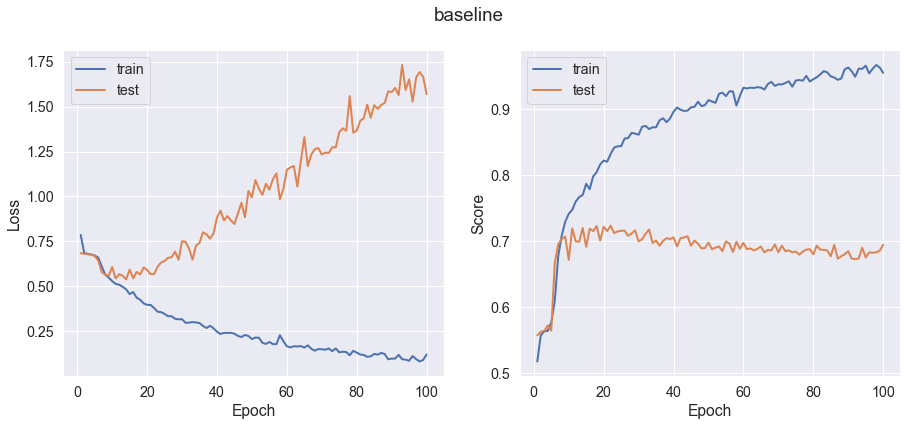

In [9]:
multihead_history = train(baseline, train_dataloader, test_dataloader, num_epochs=100, name='baseline')

In [14]:
print(f'attention parameters: {count_parameters(multihead_attention)}')
print(f'total parameters: {count_parameters(baseline)}')

attention parameters: 66048
total parameters: 464385


In [15]:
baseline.load_state_dict(torch.load('./weights/baseline.pth'));

bs = 2
length = np.arange(256, 2 ** 13 + 1, 256)
timings, memory = [], []
for l in tqdm(length):
    timing = benchmark(baseline.encoder, input_shape=(bs, l, hidden_size))
    mem = memory_usage(baseline.encoder, input_shape=(bs, l, hidden_size))
    
    timings.append(timing)
    memory.append(mem)
    
baseline_timings = np.array(timings)
baseline_memory = np.array(memory)

### Performer

In [16]:
performer_attention = PerformerAttention(hidden_dim=hidden_size, num_heads=num_heads)
performer = BaselineClf(
    performer_attention, hidden_size, num_types, num_codes, max_sequence_len, num_layers, dim_feedforward
).to(device)

epoch: 100
time per 1 epochs: 1.91s
train score: 75.89
val score: 73.15


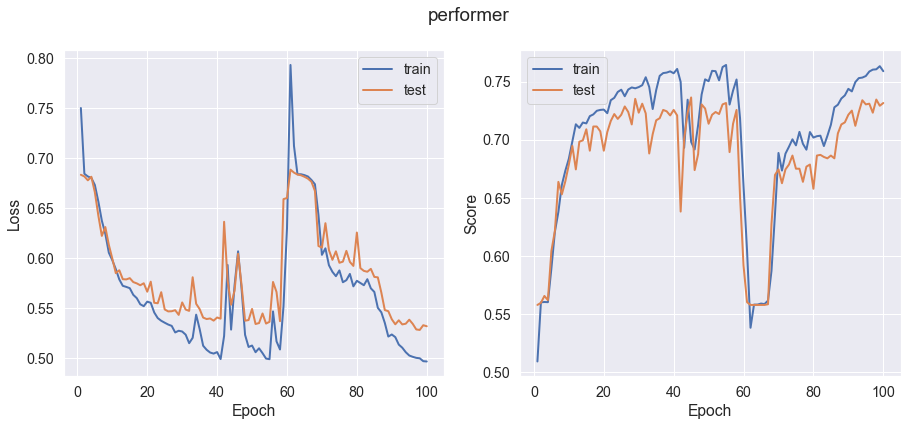

In [15]:
performer_history = train(performer, train_dataloader, test_dataloader, num_epochs=100, name='performer')

In [17]:
print(f'attention parameters: {count_parameters(performer_attention)}')
print(f'total parameters: {count_parameters(performer)}')

attention parameters: 33024
total parameters: 398337


In [18]:
performer.load_state_dict(torch.load('./weights/performer.pth'));

bs = 2
length = np.arange(256, 2 ** 13 + 1, 256)
timings, memory = [], []
for l in tqdm(length):
    timing = benchmark(performer.encoder, input_shape=(bs, l, hidden_size))
    mem = memory_usage(performer.encoder, input_shape=(bs, l, hidden_size))
    
    timings.append(timing)
    memory.append(mem)
    
performer_timings = np.array(timings)
performer_memory = np.array(memory)

### Informer

In [20]:
config = {
    'head_size': hidden_size  // num_heads, 
    'length': max_sequence_len, 
    'target_len': 70, 
    'attn_func': 'softmax', 
    'attn_num_basis': 100, 
    'attn_drop': 0.1, 
    'infinite_memory': True, 
    'n_layers': num_layers, 
    'n_heads': num_heads, 
    'd_model': hidden_size, 
    'mask': True, 
    'mask_type': 'cnn', 
    'kl_regularizer': True, 
    'sigma_0': 0, 
    'mu_0': 0,
    'share_mask': True,
    'device': 'cpu'
}

informer_attention = InformerAttention(**config)
informer = BaselineClf(
    informer_attention, hidden_size, num_types, num_codes, max_sequence_len, num_layers, dim_feedforward
).to(device)

epoch: 100
time per 1 epochs: 2.73s
train score: 83.74
val score: 72.56


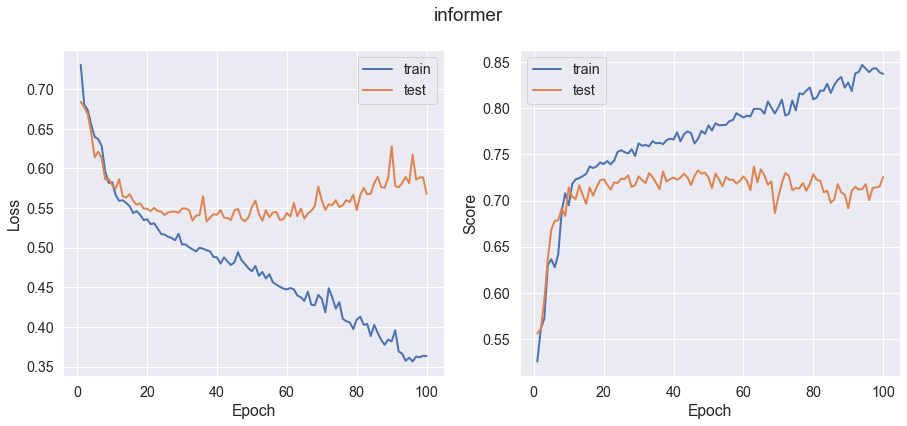

In [18]:
informer_history = train(informer, train_dataloader, test_dataloader, num_epochs=100, name='informer')

In [21]:
print(f'attention parameters: {count_parameters(informer_attention)}')
print(f'total parameters: {count_parameters(informer)}')

attention parameters: 115016
total parameters: 562321


In [19]:
bs = 2
length = np.arange(256, 2 ** 13 + 1, 256)

timings, memory = [], []
for l in tqdm(length):
    config['length'] = l

    informer_attention = InformerAttention(**config)
    informer = BaselineClf(
        informer_attention, hidden_size, num_types, num_codes, max_sequence_len, num_layers, dim_feedforward
    ).to(device)
    informer.load_state_dict(torch.load('./weights/informer.pth'));
    
    timing = benchmark(informer.encoder, input_shape=(bs, l, hidden_size))
    mem = memory_usage(informer.encoder, input_shape=(bs, l, hidden_size))
    
    timings.append(timing)
    memory.append(mem)
    
informer_timings = np.array(timings)
informer_memory = np.array(memory)

  0%|          | 0/32 [00:00<?, ?it/s]

### Comparison

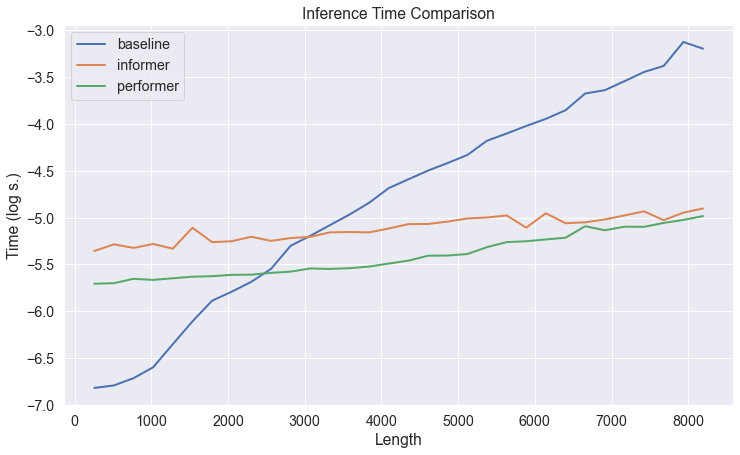

In [69]:
plt.figure(figsize=(12, 7))
plt.title('Inference Time Comparison')
plt.plot(length, np.log(baseline_timings), label='baseline', lw=2)
plt.plot(length, np.log(informer_timings), label='informer', lw=2)
plt.plot(length, np.log(performer_timings), label='performer', lw=2)
plt.xlabel('Length')
plt.ylabel('Time (log s.)')
plt.legend()
plt.show()

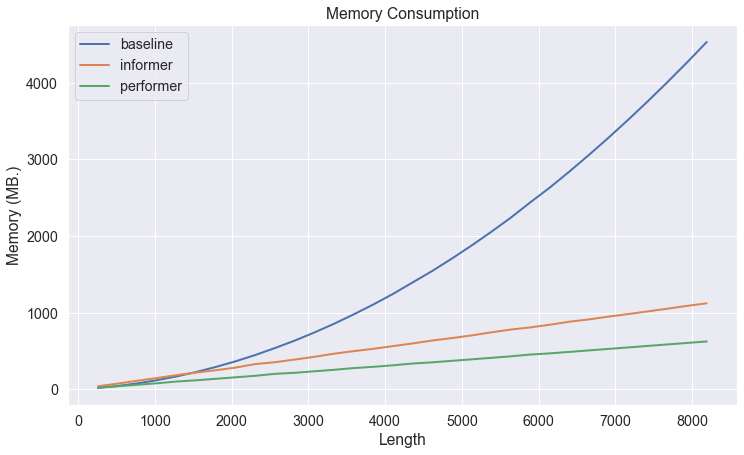

In [74]:
plt.figure(figsize=(12, 7))
plt.title('Memory Consumption')
plt.plot(length, baseline_memory, label='baseline', lw=2)
plt.plot(length, informer_memory, label='informer', lw=2)
plt.plot(length, performer_memory, label='performer', lw=2)
plt.xlabel('Length')
plt.ylabel('Memory (MB.)')
plt.legend()
plt.show()